In [7]:
%matplotlib inline
import numpy as np
from glob import glob
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from venn import venn
from collections import Counter
from matplotlib.colors import DivergingNorm

In [8]:
### Load data: absrel GO enrichemnts
v = 'combined_default_srv_mh' 
dir_path = '/Users/osipova/Documents/LabDocs/NectarivoryProject/absrel/absrel_analysis_2024/{}/ClusterProfiler/'.format(v)

nectar_clades    = ['hmmbrds', 'nectar_parrots', 'honeyeaters', 'sunbirds']
nonnectar_clades = ['swifts', 'falcons', 'lyrebirds', 'passerides']

all_results = {}

clades = nectar_clades + nonnectar_clades
for clade in clades:
    file_name = 'goenrich.{}.under_selection_per_clade_0.05.tsv'.format(clade)
    file_data = glob(dir_path + file_name)[0]
    df = pd.read_csv(file_data, sep='\t')
    all_results[clade] = df

In [14]:
### Load data: RNAseq GO enrichemnts
v = 'Intra_species_DESeq2_results'
dir_path = '/Users/osipova/Documents/LabDocs/Bird_transcriptomics/Transcriptome_for_NectarGenomics/{}/ClusterProfiler/'.format(v)

nectar_clades    = ['Annas_hummingbird', 'New_Holland_honeyeater', 'rainbow_lorikeet']
nonnectar_clades = ['common_swift', 'zebra_finch', 'cockatiel']

all_results = {}
t = 'liver'

clades = nectar_clades + nonnectar_clades
for clade in clades:
    file_name = 'goenrich.up_{}_genes_{}_not_*.tsv'.format(t, clade)
    file_data = glob(dir_path + file_name)[0]
    df = pd.read_csv(file_data, sep='\t')
    all_results[clade] = df

In [16]:
### Count in how many groups each GO is present

def count_gos(clades):
    all_goids = []
    for clade in clades:
        all_goids.extend(all_results[clade][all_results[clade]['pvalue'] < 0.05]['ID'])
    return Counter(all_goids)

nonnectar_go_count = count_gos(nonnectar_clades)
nectar_go_count = count_gos(nectar_clades)

rank3_nonnectar_go = [k for k in nonnectar_go_count if nonnectar_go_count[k] >= 3]
rank2_nectar_go = [k for k in nectar_go_count if nectar_go_count[k] >= 2]
rank3_nectar_go = [k for k in nectar_go_count if nectar_go_count[k] >= 3]
print(len(rank3_nonnectar_go))
print(len(rank2_nectar_go))
print(len(rank3_nectar_go))


28
59
7


In [17]:
### Exclude control GO ids from target

data_rank3_nectar = {}
for clade in nectar_clades:
    df_clade = all_results[clade]
    filt_df_clade = df_clade[(df_clade['ID'].isin(rank3_nectar_go) 
                              & (~df_clade['ID'].isin(rank3_nonnectar_go)))][['ID', 'Description', 'pvalue']]
    data_rank3_nectar[clade] = filt_df_clade
    
merged_df = pd.DataFrame({'ID': [], 'Description': []})
for clade in data_rank3_nectar:
    df = data_rank3_nectar[clade]
    df['logP_{}'.format(clade)] = np.log10(df['pvalue'])
    df.drop('pvalue', axis=1, inplace=True)
    merged_df = pd.merge(merged_df, df, on=['ID', 'Description'], how='outer')
    merged_df.set_index('Description', inplace=True)

In [18]:
merged_df

,ID,logP_Annas_hummingbird,logP_New_Holland_honeyeater,logP_rainbow_lorikeet
Description,,,,
lipid catabolic process,GO:0016042,-5.688439,-1.516027,-1.543353
fatty acid metabolic process,GO:0006631,-3.083546,-3.469076,-3.202345
response to virus,GO:0009615,-2.914546,-2.036198,-1.654700
glycoprotein metabolic process,GO:0009100,-2.670517,-1.567615,-2.473435
phosphatidylcholine metabolic process,GO:0046470,-2.446554,-1.870075,-2.147220
monocarboxylic acid metabolic process,GO:0032787,-2.287391,-2.201890,-4.300362
lipid modification,GO:0030258,-2.249296,-1.655205,-1.938701


/Users/osipova/local/Homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  if __name__ == '__main__':
/Users/osipova/local/Homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


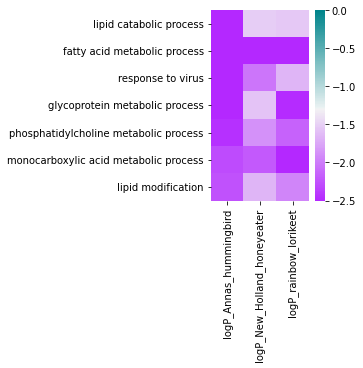

In [21]:
## purple color palette
cmap_pval = sns.diverging_palette(285, 200, 100, as_cmap=True)

## absrel
vmin = -2.5
## RANseq
vmin = -6

divnorm_pval = DivergingNorm(vmin=-2.5, vmax=0, vcenter=np.log10(0.051))

pval_cols = [i for i in merged_df.columns if i.startswith('logP_')]
df_pval = merged_df[pval_cols]

fig, axes = plt.subplots(figsize=(2.2, 3.5))
sns.heatmap(data=df_pval, cmap=cmap_pval, norm=divnorm_pval)


# axes.set_xticklabels(df_pval['GO'])
axes.set_ylabel('')
fig.tight_layout()

pdf_name = 'clusterProfiler.absrel_2024_results.4_lists.pdf'
# plt.savefig(pdf_name, format='pdf', bbox_inches="tight")

goenrich.rank1.nectar.not_nonnectar.tsv
yes
goenrich.rank2.nectar.not_nonnectar.tsv
goenrich.rank3.nectar.not_nonnectar.tsv
yes
goenrich.rank4.nectar.not_nonnectar.tsv
yes


/Users/osipova/local/Homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:26: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
/Users/osipova/local/Homebrew/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


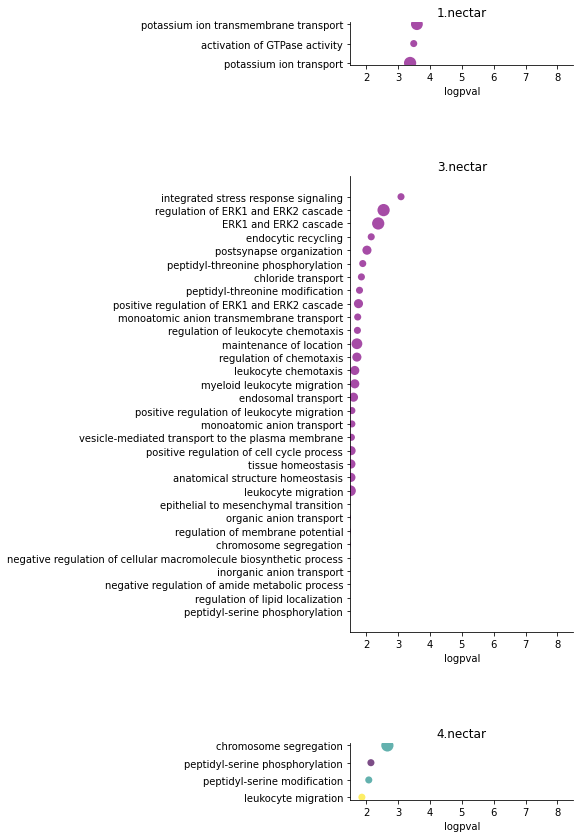

In [138]:
## GO Enrichmens SweepFinder2. ClusterProfiler
dir_path = '/Users/osipova/Documents/LabDocs/NectarivoryProject/absrel/absrel_analysis_2024/{}/ClusterProfiler/'.format(v)
dbs = ['1.nectar', '2.nectar', '3.nectar', '4.nectar']

# q_cutoff = 0.5
p_cutoff = 0.5
count_cutoff = 4
count_cutoff = 3

## Load data
DF_dbs = {}
nonzero_dbs = []
for db in dbs:
#     file_name = 'PopGen_{}/SF2.go_enrich.1Mb_domain.tsv'.format(db)
    file_name = 'goenrich.rank{}.not_nonnectar.tsv'.format(db)
    print(file_name)
    file_data = glob(dir_path + file_name)[0]
    df = pd.read_csv(file_data, sep='\t')
    df = df[df['p.adjust'] < p_cutoff]
    df = df[df['Count'] >= count_cutoff]
    
    if df.shape[0] > 0:
        print('yes')
        df['GOfull'] = df['Description'] + '  ' + df['ID']
        df['logpval'] = - np.log10(df['pvalue'])
        df['ngenes'], df['nset'] = df['GeneRatio'].str.split('/').str
        df['ratio'] = (pd.to_numeric(df['ngenes']) / pd.to_numeric(df['nset']) * 1000).astype(int)
        DF_dbs[db] = df
        nonzero_dbs.append(db)


## Plot barplots p-value DoS > 0 and DoS < 0
db_ratios = [DF_dbs[db].shape[0] for db in nonzero_dbs]
fig, axes = plt.subplots(len(nonzero_dbs), 1, gridspec_kw={'height_ratios': db_ratios}, 
                         figsize=(4, 6*len(nonzero_dbs)))

blue = '#2b83ba'
red = '#d7191c'
c = 'purple'
min_ratio = 50
max_ratio = 150

i = 0
for db in nonzero_dbs:
    axi = axes[i]
    dfi = DF_dbs[db]
    sns.scatterplot(ax=axi, data=dfi, x='logpval', y='Description', size='ratio',
                    sizes=(min_ratio, max_ratio), color=c, alpha=0.7, linewidth=0)
    axi.set(xlim=(1.5, 8.5), ylabel='')
    axi.set_title(db)
    axi.legend([], [], frameon=False)
    i += 1
    
sns.despine(fig=None, ax=None, left=False, bottom=False, offset=None, trim=False) 
fig.subplots_adjust(bottom=0, top=0.6, wspace=0, hspace=0.6)
fig.tight_layout()

pdf_name = 'SF2.enrichGO.withBG.clusterProfiler.1Mb_domain.pdf'
# fig.savefig(pdf_name, bbox_inches='tight')